In [1]:
from torch.utils.data.dataset import T_co
# % matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
# from torch.nn import functional
# from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation

SEQ_LENGTH = 60

device = torch.device(0)

In [2]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)  # [[int,...],...]
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)  # [[int,...],...]
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')  # [str,...]

In [3]:
class LanguageModelSet(Dataset):

    def __init__(self, data_loaded):
        super().__init__()
        data = torch.from_numpy(np.concatenate(data_loaded))

        self.len = (data.shape[0] - 1) // SEQ_LENGTH

        self.input = torch.zeros((self.len, SEQ_LENGTH), dtype=torch.long)
        self.target = torch.zeros_like(self.input)

        for i in range(self.len):
            self.input[i] = data[i * SEQ_LENGTH:(i + 1) * SEQ_LENGTH]
            self.target[i] = data[i * SEQ_LENGTH + 1:(i + 1) * SEQ_LENGTH + 1]

    def __getitem__(self, index) -> T_co:
        return self.input[index], self.target[index]

    def __len__(self):
        return self.len


# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """

    def __init__(self, dataset, batch_size, shuffle=True):
        super(LanguageModelDataLoader, self).__init__(LanguageModelSet(dataset), batch_size, shuffle)

    # def __iter__(self):
    #     # concatenate your articles and build into batches
    #
    #     raise NotImplemented




In [4]:
# model

class LockedDropOut(nn.Module):
    def __init__(self, p, batch_dim=0):
        super().__init__()
        self.keep = 1 - p
        self.batch_dim = 0

    def forward(self, x):
        """
        :param x: (B,T,C)
        :return:
        """
        if not self.training:
            return x
        if self.batch_dim == 0:
            mask = torch.zeros((1, x.shape[1], x.shape[2]), requires_grad=False, device=x.device).bernoulli_(self.keep)
        else:
            mask = torch.zeros((x.shape[0], 1, x.shape[2]), requires_grad=False, device=x.device).bernoulli_(self.keep)

        mask /= self.keep
        mask = mask.expand_as(x)
        return mask * x


class LanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super(LanguageModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, 400)

        self.d0 = LockedDropOut(0.65)
        self.r1 = nn.LSTM(input_size=400, hidden_size=1150, num_layers=1, batch_first=True)
        self.d1 = LockedDropOut(0.3)
        self.r2 = nn.LSTM(1150, 1150, batch_first=True)
        self.d2 = LockedDropOut(0.3)
        self.r3 = nn.LSTM(1150, 400, batch_first=True)
        self.d3 = LockedDropOut(0.4)

        self.linear = nn.Linear(400, vocab_size)
        self.linear.weight = self.embedding.weight

        for weight in self.parameters():
            nn.init.uniform_(weight, -1 / np.sqrt(1150), 1 / np.sqrt(1150))

        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)

    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        # x: (B,SEQ)

        x = self.embedding(x)

        # print(x.shape)

        x = self.r1(self.d0(x))[0]
        x = self.r2(self.d1(x))[0]
        x = self.r3(self.d2(x))[0]
        x = self.d3(x)
        x = self.linear(x)

        return torch.transpose(x, 1, 2)  # B, ENCODING, SEQ




In [5]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model.cuda()
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id

        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.SGD(self.model.parameters(), 1, momentum=0.9)
        self.criterion = nn.CrossEntropyLoss().cuda()

    def train(self):
        self.model.train()  # set to training mode
        epoch_loss = 0
        batch_num = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
              % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """
            TODO: Define code for training a single batch of inputs

        """
        output = self.model(inputs.to(device))
        # print(output.shape)
        # print(targets.shape)
        loss = self.criterion(output, targets.to(device))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def test(self):
        # don't change these
        self.model.eval()  # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model)  # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10,
                                                        self.model)  # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)

        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)

        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model)  # get predictions
        self.predictions_test.append(predictions_test)

        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
              % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
                   model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)),
                self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)),
                self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)),
                self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)),
                self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [6]:
class TestLanguageModel:
    @staticmethod
    def prediction(inp, model):
        """
            TODO: write prediction code here

            :param inp:
            :return: a np.ndarray of logits
        """

        inp = torch.from_numpy(inp)
        inp = inp.to(device)

        return model(inp).cpu().detach().numpy()

    @staticmethod
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """

        inp = torch.from_numpy(inp)
        inp = inp.to(device)

        result = torch.zeros((inp.shape[0], forward), device=inp.device, dtype=torch.long)

        # res = model(inp)[:, :, -1]
        # print(res.shape)

        result[:, 0] = torch.argmax(model(inp)[:, :, -1], 1)
        for i in range(1, forward):
            result[:, i] = torch.argmax(model(torch.unsqueeze(result[:, i - 1], 1))[:, :, -1], 1)

        return result.cpu().detach().numpy()


In [7]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 6
BATCH_SIZE = 80


In [8]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1618812260


In [9]:
model = LanguageModel(len(vocab))

loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [10]:
best_nll = 1e30
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch " + str(epoch) + " with NLL: " + str(best_nll))
        trainer.save()


[TRAIN]  Epoch [2/6]   Loss: 8.7498
[VAL]  Epoch [2/6]   Loss: 7.5962
Saving model, predictions and generated output for epoch 0 with NLL: 7.5961714
[TRAIN]  Epoch [3/6]   Loss: 7.7199
[VAL]  Epoch [3/6]   Loss: 7.2800
Saving model, predictions and generated output for epoch 1 with NLL: 7.28
[TRAIN]  Epoch [4/6]   Loss: 7.5571
[VAL]  Epoch [4/6]   Loss: 7.1266
Saving model, predictions and generated output for epoch 2 with NLL: 7.126577
[TRAIN]  Epoch [5/6]   Loss: 7.4656
[VAL]  Epoch [5/6]   Loss: 7.0382
Saving model, predictions and generated output for epoch 3 with NLL: 7.0381713
[TRAIN]  Epoch [6/6]   Loss: 7.4058
[VAL]  Epoch [6/6]   Loss: 6.9656
Saving model, predictions and generated output for epoch 4 with NLL: 6.9655747
[TRAIN]  Epoch [7/6]   Loss: 7.3636
[VAL]  Epoch [7/6]   Loss: 6.9226
Saving model, predictions and generated output for epoch 5 with NLL: 6.9226217


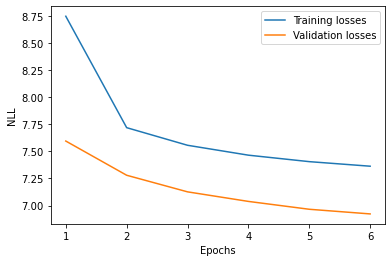

In [11]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [12]:
# see generated output
print(trainer.generated[-1])  # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the the the the the the the the the the
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | the the the the the the the the the the
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | the the the the the the the the the the
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | the the the the the the the the the the
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | the the the the the the the the the the
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | the the the the the the the the the the
Input | Output #6: <unk> , $ 96 million USD ) . Damage was